# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
from models import Model_1

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 181374325.97it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 41944492.32it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 49295000.55it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 3381950.78it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


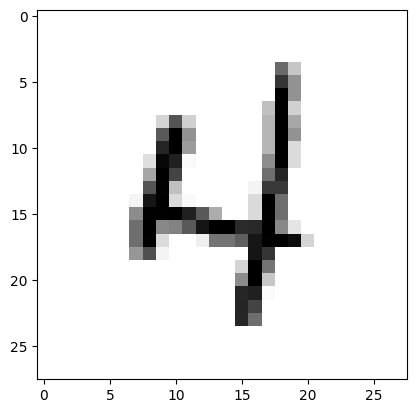

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

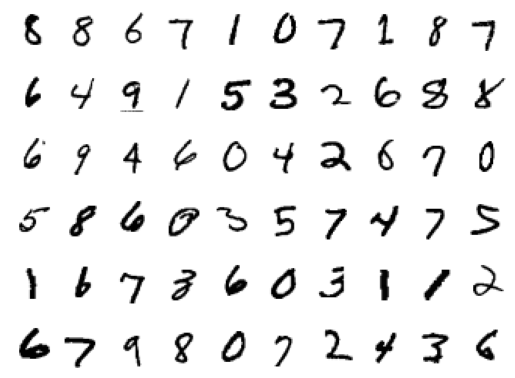

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
Net = Model_1

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
       BatchNorm2d-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 32, 22, 22]           4,608
      BatchNorm2d-10           [-1, 32, 22, 22]              64
             ReLU-11           [-1, 32, 22, 22]               0
          Dropout-12           [-1, 32, 22, 22]               0
        MaxPool2d-13           [-1, 32, 11, 11]               0
           Conv2d-14            [-

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [11]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=0.049827683717012405 Batch_id=468 Accuracy=92.39: 100%|██████████| 469/469 [00:18<00:00, 25.33it/s]



Test set: Average loss: 0.0794, Accuracy: 9749/10000 (97.49%)

EPOCH: 1


Loss=0.018601808696985245 Batch_id=468 Accuracy=97.60: 100%|██████████| 469/469 [00:15<00:00, 29.93it/s]



Test set: Average loss: 0.0399, Accuracy: 9878/10000 (98.78%)

EPOCH: 2


Loss=0.025161834433674812 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:18<00:00, 25.43it/s]



Test set: Average loss: 0.0366, Accuracy: 9887/10000 (98.87%)

EPOCH: 3


Loss=0.02262508124113083 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:15<00:00, 29.37it/s]



Test set: Average loss: 0.0351, Accuracy: 9885/10000 (98.85%)

EPOCH: 4


Loss=0.013412429951131344 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:15<00:00, 30.05it/s]



Test set: Average loss: 0.0256, Accuracy: 9915/10000 (99.15%)

EPOCH: 5


Loss=0.054463014006614685 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:17<00:00, 27.55it/s]



Test set: Average loss: 0.0278, Accuracy: 9902/10000 (99.02%)

EPOCH: 6


Loss=0.020389525219798088 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:16<00:00, 28.19it/s]



Test set: Average loss: 0.0310, Accuracy: 9904/10000 (99.04%)

EPOCH: 7


Loss=0.014815772883594036 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:16<00:00, 28.80it/s]



Test set: Average loss: 0.0249, Accuracy: 9923/10000 (99.23%)

EPOCH: 8


Loss=0.011368848383426666 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:15<00:00, 29.64it/s]



Test set: Average loss: 0.0246, Accuracy: 9919/10000 (99.19%)

EPOCH: 9


Loss=0.054999154061079025 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:15<00:00, 30.06it/s]



Test set: Average loss: 0.0249, Accuracy: 9922/10000 (99.22%)

EPOCH: 10


Loss=0.04760614037513733 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:16<00:00, 27.70it/s]



Test set: Average loss: 0.0221, Accuracy: 9925/10000 (99.25%)

EPOCH: 11


Loss=0.0031285828445106745 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:15<00:00, 29.88it/s]



Test set: Average loss: 0.0260, Accuracy: 9916/10000 (99.16%)

EPOCH: 12


Loss=0.003472186392173171 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:16<00:00, 28.34it/s]



Test set: Average loss: 0.0223, Accuracy: 9924/10000 (99.24%)

EPOCH: 13


Loss=0.007084503769874573 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:15<00:00, 29.83it/s]



Test set: Average loss: 0.0214, Accuracy: 9934/10000 (99.34%)

EPOCH: 14


Loss=0.023898174986243248 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:15<00:00, 30.16it/s]



Test set: Average loss: 0.0257, Accuracy: 9911/10000 (99.11%)



Text(0.5, 1.0, 'Test Accuracy')

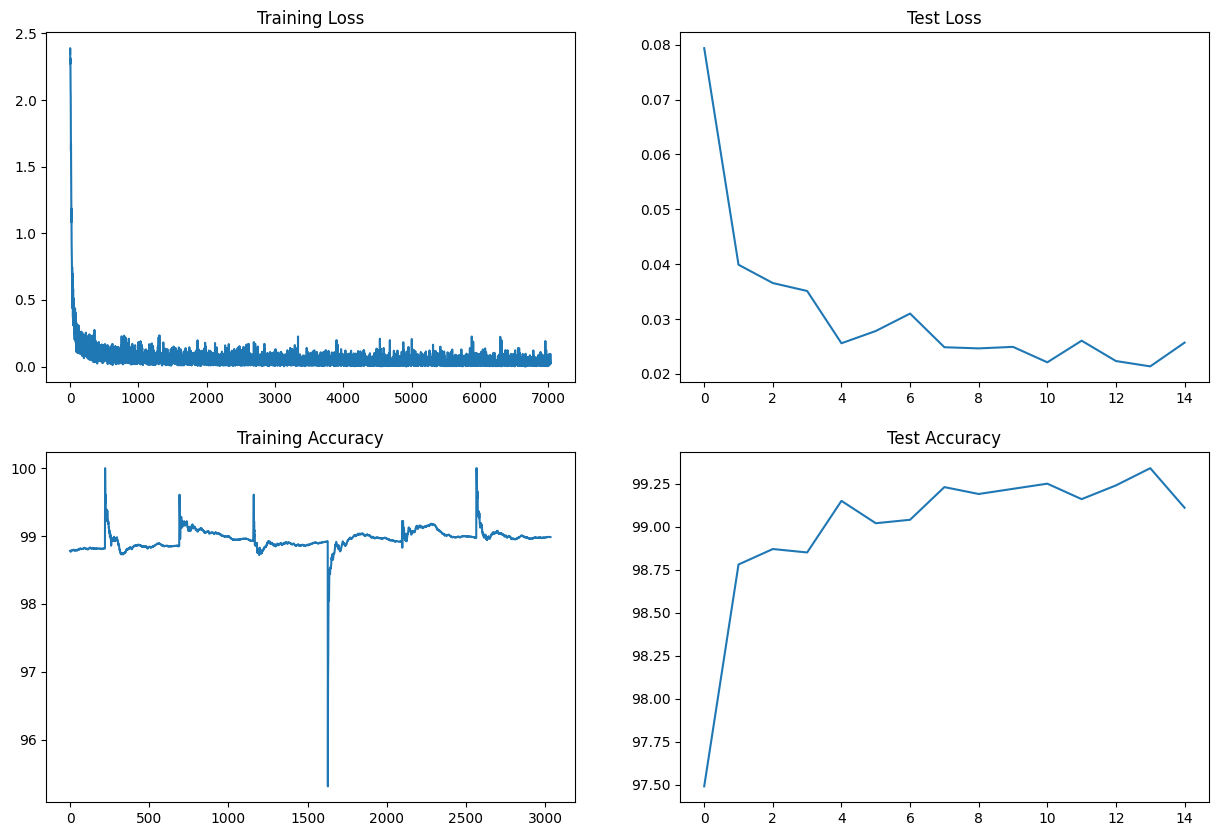

In [12]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Target:
  1. Get the set-up right
  2. Set Transforms
  3. Set Data Loader
  4. Set Basic Working Code
  5. Set Basic Training  & Test Loop
  6. Get the basic skeleton right. We will try and avoid changing this skeleton as much as possible.
  7. Lighter model
  8. Add batch norm to inc efficiency
  9. Add dropout as a part of regularization

Results:
  1. Parameters: 12k
  2. Best Train Accuracy: 98.98
  3. Best Test Accuracy: 99.34

Analysis:
  1. The model is still large, but working, need to get down to 8k parameters
  2. not over-fitting
  3. Consistently  99.4 accuracy is not seen.
